<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Papers/blob/main/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os
import cv2
import glob
import matplotlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn import model_selection
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()

tf.__version__

'2.11.0'

##Data

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d andrewmvd/car-plate-detection
!unzip \*.zip && rm *.zip

In [3]:
IMAGE_PATH = '/content/data/images/'
ANNOTATION_PATH =  '/content/data/annotations/'

os.makedirs('/content/data/', exist_ok=True)
os.replace('/content/images', '/content/data/images')
os.replace('/content/annotations', '/content/data/annotations')

In [37]:
def xml_to_XY(path, img_path):
  Y = []
  X = []
  for xml_file in glob.glob(path+'*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    img_name = img_path + xml_file.replace(path, '')[:-4]+'.png'

    h, w, d = plt.imread(img_name).shape

    img = tf.keras.preprocessing.image.load_img(img_name, target_size=(320, 320))
    img_arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0

    for children in root.findall('object'):
      bndbox = children[5]
      # xmin = float(bndbox[0].text) / w
      # ymin = float(bndbox[1].text) / h
      # xmax = float(bndbox[2].text) / w
      # ymax = float(bndbox[3].text) / h
      xmin = float(bndbox[0].text)
      ymin = float(bndbox[1].text)
      xmax = float(bndbox[2].text)
      ymax = float(bndbox[3].text)
      X.append(img_arr)
      Y.append([xmin, ymin, xmax, ymax])

  return X, Y

In [38]:
x, y = xml_to_XY(ANNOTATION_PATH, IMAGE_PATH)

In [39]:
x = np.array(x)
y = np.array(y)
x.shape, y.shape

((471, 320, 320, 3), (471, 4))

In [40]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y, test_size=0.2, random_state=26)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((376, 320, 320, 3), (95, 320, 320, 3), (376, 4), (95, 4))

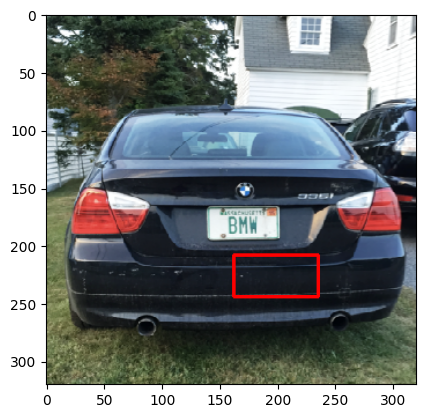

In [45]:
# N = 0
N += 1
img = train_x[N]
y = train_y[N]
image = cv2.rectangle(img, (int(y[0]), int(y[1])), (int(y[2]), int(y[3])), color=(255, 0, 0), thickness=2)
plt.imshow(image) 
plt.show()

#Part 1

##Model

In [ ]:
num_classes = 1
base_model = tf.keras.applications.VGG16(input_shape=[320, 320, 3], include_top=False)
base_model.trainable = False

# Define the RPN
rpn_conv = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', name='rpn_conv')
rpn_cls  = tf.keras.layers.Conv2D(9 * 2, 1, name='rpn_cls')
rpn_reg  = tf.keras.layers.Conv2D(9 * 4, 1, name='rpn_reg')

# Define the RoI pooling layer
roi_pooling = tf.keras.layers.Lambda(lambda x: tf.image.crop_and_resize(*x), name='roi_pooling')

# Define the classifier
classifier = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes + 1)
])
regressor = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes * 4)
])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Define the complete Faster R-CNN model
inputs = tf.keras.Input(shape=[None, None, 3])
x = base_model(inputs)
x_rpn_conv = rpn_conv(x)
x_rpn_cls = rpn_cls(x_rpn_conv)
x_rpn_reg = rpn_reg(x_rpn_conv)

rpn = tf.keras.Model(inputs, [x_rpn_cls, x_rpn_reg])

In [ ]:
x_rpn_cls, x_rpn_reg
x_rpn_conv
x

<KerasTensor: shape=(None, 10, 10, 512) dtype=float32 (created by layer 'vgg16')>

In [ ]:
def generate_anchors(base_size=16, ratios=[0.5, 1, 2], scales=[8, 16, 32]):
    # Compute the base anchor
    base_anchor = tf.constant([1, 1, base_size, base_size], dtype=tf.float32) - 1

    # Compute the ratio anchors
    ratio_anchors = _ratio_enum(base_anchor, ratios)

    # Compute the scale anchors
    anchors = tf.concat([_scale_enum(ratio_anchors[i, :], scales) for i in range(ratio_anchors.shape[0])], axis=0)
    return anchors

def _xy_to_whCenter(anchor):
    #Xmin, Xmax, Ymin, Ymax ==> width, height, Xcenter, Ycenter
    x1, y1, x2, y2 = anchor
    w = x2 - x1 + 1
    h = y2 - y1 + 1
    x_ctr = x1 + (w-1)/2
    y_ctr = y1 + (h-1)/2
    return w, h, x_ctr, y_ctr


def _mkanchors(ws , hs , x_ctr , y_ctr):
# Given a vector of widths (ws) and heights (hs) around a center (x_ctr,y_ctr), output a set of anchors (windows).
  ws=tf.reshape(ws , [-1 , 1])
  hs=tf.reshape(hs , [-1 , 1])

  anchors=tf.concat([x_ctr - 0.5 * (ws-1), y_ctr - 0.5 * (hs-1), x_ctr + 0.5 * (ws-1), y_ctr + 0.5 * (hs-1)],axis=-1)
  return anchors

def _ratio_enum(anchor, ratios):
# Enumerate a set of anchors for each aspect ratio wrt an anchor.
  w, h, x_ctr, y_ctr = _xy_to_whCenter(anchor)
  size = w * h
  size_ratios = size / ratios
  ws = tf.round(tf.sqrt(size_ratios))
  hs = ws * ratios
  anchors=_mkanchors(ws , hs , x_ctr , y_ctr)
  return anchors

def _scale_enum(anchor,scales):
# Enumerate a set of anchors for each scale wrt an anchor.
  w, h, x_ctr, y_ctr=_xy_to_whCenter(anchor)
  ws=w*scales 
  hs=h*scales 
  anchors=_mkanchors(ws , hs , x_ctr , y_ctr)
  return anchors

In [ ]:
anchors = generate_anchors(base_size=16, ratios=[0.5, 1, 2], scales=[8, 16, 32])
anchors

<tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[ -84.,  -38.,   99.,   53.],
       [-176.,  -84.,  191.,   99.],
       [-360., -176.,  375.,  191.],
       [ -56.,  -56.,   71.,   71.],
       [-120., -120.,  135.,  135.],
       [-248., -248.,  263.,  263.],
       [ -36.,  -80.,   51.,   95.],
       [ -80., -168.,   95.,  183.],
       [-168., -344.,  183.,  359.]], dtype=float32)>

In [ ]:
def rpn_to_roi(rpn_cls, rpn_reg, anchors):
    # Convert logits to probabilities
    rpn_cls_prob = tf.nn.softmax(rpn_cls)

    # Get the foreground probabilities for each anchor
    fg_prob = rpn_cls_prob[..., 1]

    # Decode the predicted bounding boxes
    pred_boxes = decode_boxes(rpn_reg, anchors)

    # Apply non-maximum suppression to remove overlapping boxes
    indices = tf.image.non_max_suppression(pred_boxes, fg_prob,
                                           max_output_size=2000,
                                           iou_threshold=0.7)

    rois = tf.gather(pred_boxes, indices)
    
    return rois
    

def decode_boxes(deltas, anchors):
    # Compute the width and height of each anchor box
    wa = anchors[..., 2] - anchors[..., 0]
    ha = anchors[..., 3] - anchors[..., 1]

    # Compute the center coordinates of each anchor box
    xa = (anchors[..., 2] + anchors[..., 0]) / 2
    ya = (anchors[..., 3] + anchors[..., 1]) / 2

    # Decode the predicted bounding box deltas
    ty = deltas[..., 0]
    tx = deltas[..., 1]
    th = deltas[..., 2]
    tw = deltas[..., 3]
    print(deltas[..., 3].shape)
    w = tf.math.multiply(tf.math.exp(tw), wa)
    h = tf.math.multiply(tf.math.exp(th), ha)

    y = ty * ha + ya
    x = tx * wa + xa

    # Compute the coordinates of the decoded bounding boxes
    y1=x-w/2 
    x1=y-h/2 
    y2=x+w/2 
    x2=y+h/2 

    return tf.stack([y1,x1,y2,x2],axis=-1)

In [ ]:
rois = rpn_to_roi(x_rpn_cls, x_rpn_reg, anchors) # Generate RoIs using the RPN outputs

pooled_rois = roi_pooling([x] + rois)

cls_output = classifier(pooled_rois)
reg_output = regressor(pooled_rois)

faster_rcnn = tf.kers.Model(inputs, [cls_output, reg_output])

In [ ]:
rpn_reg[..., 0]

In [ ]:
rpn_reg[..., 0]

##Test

In [ ]:
import torch as tt
import numpy as np
from utils import array_tool as at
from model.utils.bbox_tools import loc2bbox
from torchvision.ops import nms

from torch import nn
from data.dataset import preprocess
from torch.nn import functional as F
from utils.config import opt


def nograd(f):
    def new_f(*args,**kwargs):
        with t.no_grad():
           return f(*args,**kwargs)
    return new_f

class FasterRCNN(nn.Module):HW image
    def __init__(self, extractor, rpn, head,
                loc_normalize_mean = (0., 0., 0., 0.),
                loc_normalize_std = (0.1, 0.1, 0.2, 0.2)):
      
        super(FasterRCNN, self).__init__()
        self.extractor = extractor
        self.rpn = rpn
        self.head = head

        # mean and std
        self.loc_normalize_mean = loc_normalize_mean
        self.loc_normalize_std = loc_normalize_std
        self.use_preset('evaluate')

    @property
    def n_class(self):
        # Total number of classes including the background.
        return self.head.n_class

    def forward(self, x, scale=1.):
        img_size = x.shape[2:]

        h = self.extractor(x)
        rpn_locs, rpn_scores, rois, roi_indices, anchor = \
            self.rpn(h, img_size, scale)
        roi_cls_locs, roi_scores = self.head(
            h, rois, roi_indices)
        return roi_cls_locs, roi_scores, rois, roi_indices

    def use_preset(self, preset):
        if preset == 'visualize':
            self.nms_thresh = 0.3
            self.score_thresh = 0.7
        elif preset == 'evaluate':
            self.nms_thresh = 0.3
            self.score_thresh = 0.05
        else:
            raise ValueError('preset must be visualize or evaluate')

    def _suppress(self, raw_cls_bbox, raw_prob):
        bbox = list()
        label = list()
        score = list()
        # skip cls_id = 0 because it is the background class
        for l in range(1, self.n_class):
            cls_bbox_l = raw_cls_bbox.reshape((-1, self.n_class, 4))[:, l, :]
            prob_l = raw_prob[:, l]
            mask = prob_l > self.score_thresh
            cls_bbox_l = cls_bbox_l[mask]
            prob_l = prob_l[mask]
            keep = nms(cls_bbox_l, prob_l,self.nms_thresh)
            # import ipdb;ipdb.set_trace()
            # keep = cp.asnumpy(keep)
            bbox.append(cls_bbox_l[keep].cpu().numpy())
            # The labels are in [0, self.n_class - 2].
            label.append((l - 1) * np.ones((len(keep),)))
            score.append(prob_l[keep].cpu().numpy())
        bbox = np.concatenate(bbox, axis=0).astype(np.float32)
        label = np.concatenate(label, axis=0).astype(np.int32)
        score = np.concatenate(score, axis=0).astype(np.float32)
        return bbox, label, score

    @nograd
    def predict(self, imgs,sizes=None,visualize=False):
        self.eval()
        if visualize:
            self.use_preset('visualize')
            prepared_imgs = list()
            sizes = list()
            for img in imgs:
                size = img.shape[1:]
                img = preprocess(at.tonumpy(img))
                prepared_imgs.append(img)
                sizes.append(size)
        else:
             prepared_imgs = imgs 
        bboxes = list()
        labels = list()
        scores = list()
        for img, size in zip(prepared_imgs, sizes):
            img = at.totensor(img[None]).float()
            scale = img.shape[3] / size[1]
            roi_cls_loc, roi_scores, rois, _ = self(img, scale=scale)
            # We are assuming that batch size is 1.
            roi_score = roi_scores.data
            roi_cls_loc = roi_cls_loc.data
            roi = at.totensor(rois) / scale

            # Convert predictions to bounding boxes in image coordinates.
            # Bounding boxes are scaled to the scale of the input images.
            mean = t.Tensor(self.loc_normalize_mean).cuda(). \
                repeat(self.n_class)[None]
            std = t.Tensor(self.loc_normalize_std).cuda(). \
                repeat(self.n_class)[None]

            roi_cls_loc = (roi_cls_loc * std + mean)
            roi_cls_loc = roi_cls_loc.view(-1, self.n_class, 4)
            roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)
            cls_bbox = loc2bbox(at.tonumpy(roi).reshape((-1, 4)),
                                at.tonumpy(roi_cls_loc).reshape((-1, 4)))
            cls_bbox = at.totensor(cls_bbox)
            cls_bbox = cls_bbox.view(-1, self.n_class * 4)
            # clip bounding box
            cls_bbox[:, 0::2] = (cls_bbox[:, 0::2]).clamp(min=0, max=size[0])
            cls_bbox[:, 1::2] = (cls_bbox[:, 1::2]).clamp(min=0, max=size[1])

            prob = (F.softmax(at.totensor(roi_score), dim=1))

            bbox, label, score = self._suppress(cls_bbox, prob)
            bboxes.append(bbox)
            labels.append(label)
            scores.append(score)

        self.use_preset('evaluate')
        self.train()
        return bboxes, labels, scores

    def get_optimizer(self):
        lr = opt.lr
        params = []
        for key, value in dict(self.named_parameters()).items():
            if value.requires_grad:
                if 'bias' in key:
                    params += [{'params': [value], 'lr': lr * 2, 'weight_decay': 0}]
                else:
                    params += [{'params': [value], 'lr': lr, 'weight_decay': opt.weight_decay}]
        if opt.use_adam:
            self.optimizer = t.optim.Adam(params)
        else:
            self.optimizer = t.optim.SGD(params, momentum=0.9)
        return self.optimizer

    def scale_lr(self, decay=0.1):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] *= decay
        return self.optimizer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from layers import *
from data import voc, coco
import os


class SSD(nn.Module):

    def __init__(self, phase, size, base, extras, head, num_classes):
        super(SSD, self).__init__()
        self.phase = phase
        self.num_classes = num_classes
        self.cfg = (coco, voc)[num_classes == 21]
        self.priorbox = PriorBox(self.cfg)
        self.priors = Variable(self.priorbox.forward(), volatile=True)
        self.size = size

        # SSD network
        self.vgg = nn.ModuleList(base)
        # Layer learns to scale the l2 normalized features from conv4_3
        self.L2Norm = L2Norm(512, 20)
        self.extras = nn.ModuleList(extras)

        self.loc = nn.ModuleList(head[0])
        self.conf = nn.ModuleList(head[1])

        if phase == 'test':
            self.softmax = nn.Softmax(dim=-1)
            self.detect = Detect(num_classes, 0, 200, 0.01, 0.45)

    def forward(self, x):
        sources = list()
        loc = list()
        conf = list()

        # apply vgg up to conv4_3 relu
        for k in range(23):
            x = self.vgg[k](x)

        s = self.L2Norm(x)
        sources.append(s)

        # apply vgg up to fc7
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)
        sources.append(x)

        # apply extra layers and cache source layer outputs
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:
                sources.append(x)

        # apply multibox head to source layers
        for (x, l, c) in zip(sources, self.loc, self.conf):
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())

        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)
        if self.phase == "test":
            output = self.detect(
                loc.view(loc.size(0), -1, 4),                   # loc preds
                self.softmax(conf.view(conf.size(0), -1,
                             self.num_classes)),                # conf preds
                self.priors.type(type(x.data))                  # default boxes
            )
        else:
            output = (
                loc.view(loc.size(0), -1, 4),
                conf.view(conf.size(0), -1, self.num_classes),
                self.priors
            )
        return output

    def load_weights(self, base_file):
        other, ext = os.path.splitext(base_file)
        if ext == '.pkl' or '.pth':
            print('Loading weights into state dict...')
            self.load_state_dict(torch.load(base_file,
                                 map_location=lambda storage, loc: storage))
            print('Finished!')
        else:
            print('Sorry only .pth and .pkl files supported.')


# This function is derived from torchvision VGG make_layers()
# https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
def vgg(cfg, i, batch_norm=False):
    layers = []
    in_channels = i
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'C':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return layers


def add_extras(cfg, i, batch_norm=False):
    # Extra layers added to VGG for feature scaling
    layers = []
    in_channels = i
    flag = False
    for k, v in enumerate(cfg):
        if in_channels != 'S':
            if v == 'S':
                layers += [nn.Conv2d(in_channels, cfg[k + 1],
                           kernel_size=(1, 3)[flag], stride=2, padding=1)]
            else:
                layers += [nn.Conv2d(in_channels, v, kernel_size=(1, 3)[flag])]
            flag = not flag
        in_channels = v
    return layers


def multibox(vgg, extra_layers, cfg, num_classes):
    loc_layers = []
    conf_layers = []
    vgg_source = [21, -2]
    for k, v in enumerate(vgg_source):
        loc_layers += [nn.Conv2d(vgg[v].out_channels,
                                 cfg[k] * 4, kernel_size=3, padding=1)]
        conf_layers += [nn.Conv2d(vgg[v].out_channels,
                        cfg[k] * num_classes, kernel_size=3, padding=1)]
    for k, v in enumerate(extra_layers[1::2], 2):
        loc_layers += [nn.Conv2d(v.out_channels, cfg[k]
                                 * 4, kernel_size=3, padding=1)]
        conf_layers += [nn.Conv2d(v.out_channels, cfg[k]
                                  * num_classes, kernel_size=3, padding=1)]
    return vgg, extra_layers, (loc_layers, conf_layers)


base = {
    '300': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'C', 512, 512, 512, 'M',
            512, 512, 512],
    '512': [],
}
extras = {
    '300': [256, 'S', 512, 128, 'S', 256, 128, 256, 128, 256],
    '512': [],
}
mbox = {
    '300': [4, 6, 6, 6, 4, 4],  # number of boxes per feature map location
    '512': [],
}


def build_ssd(phase, size=300, num_classes=21):
    if phase != "test" and phase != "train":
        print("ERROR: Phase: " + phase + " not recognized")
        return
    if size != 300:
        print("ERROR: You specified size " + repr(size) + ". However, " +
              "currently only SSD300 (size=300) is supported!")
        return
    base_, extras_, head_ = multibox(vgg(base[str(size)], 3),
                                     add_extras(extras[str(size)], 1024),
                                     mbox[str(size)], num_classes)
    return SSD(phase, size, base_, extras_, head_, num_classes)

#rrrr